## Step 1: Import the libraries

In [1]:
import os
import random

import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import retro                 # Retro Environment
from retro.retro_env import RetroEnv

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs
%matplotlib inline
from IPython import display

from collections import deque # Ordered collection with ends

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore') 

import gym

## Step 2: Create environment 

In [3]:
class SF2Env(RetroEnv):
    KEY_LIST = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
    
    def __init__(self, game, state=retro.State.DEFAULT, scenario=None, info=None, use_restricted_actions=retro.Actions.FILTERED,
                 record=False, players=1, inttype=retro.data.Integrations.STABLE, obs_type=retro.Observations.IMAGE, press_button_print=False):
        # action 입력은 DISCRETE 모드
        use_restricted_actions = retro.Actions.DISCRETE
        self.press_button_print = press_button_print
        
        RetroEnv.__init__(self, game, state, scenario, info, use_restricted_actions,
                 record, players, inttype, obs_type)
        # retro의 버그 : scenario.json의 actions를 인식하지 못하기 때문에 수동으로 세팅
        self.button_combos = self.data.valid_actions()
        if self.use_restricted_actions == retro.Actions.DISCRETE:
            combos = 1
            for combo in self.button_combos:
                combos *= len(combo)
            self.action_space = gym.spaces.Discrete(combos ** players)
        elif self.use_restricted_actions == retro.Actions.MULTI_DISCRETE:
            self.action_space = gym.spaces.MultiDiscrete([len(combos) if self.gym_version >= (0, 9, 6) else (0, len(combos) - 1) for combos in self.button_combos] * players)
        else:
            self.action_space = gym.spaces.MultiBinary(self.num_buttons * players)
    
    def step(self, a):
        ob, rew, done, info = RetroEnv.step(self, a)
        
        if self.press_button_print:
            print(self.action_array_to_keys(self.action_to_array(a)))
        
        return self.get_state_from(), rew, done, info        
    
    def reset(self):
        RetroEnv.reset(self)
        return self.get_state_from()
            
    def action_array_to_keys(self, action_array):
        press_keys = []
        for i,v in enumerate(action_array[0]):
            if v == 1:
                press_keys.append(self.KEY_LIST[i])
        return press_keys
    
    # env로부터 state 값을 변환
    def get_state_from(self):
        state = [0] * (188*71 + 2)
        
        distance_x_between_players = int(self.data.lookup_value('distance_x_between_players'))
        distance_y_between_players = int(self.data.lookup_value('distance_y_between_players'))
        
        distance_inx = distance_x_between_players * (distance_y_between_players + 1)
        # TODO 유효하지 않은 인덱스가 없도록 처리
        if distance_inx >= len(state):
            state[0] = 1
        else:
            state[distance_inx] = 1
        
        first_player_x = int(self.data.lookup_value('first_player_x'))
        second_player_x = int(self.data.lookup_value('second_player_x'))
        
        left = 0
        right = 0
        if first_player_x > second_player_x:
            right = 1
        elif first_player_x < second_player_x: 
            left = 1
        state[188*71] = left
        state[188*71 + 1] = right
        
        return np.asarray(state)

    
rom_path = os.path.dirname(os.path.abspath('.')) + '/sf2-env/StreetFighterIISpecialChampionEdition-Genesis'

env = SF2Env(rom_path, 
             state='rvsb.state', 
             scenario='scenario',
             press_button_print=False)


possible_actions = np.array(list(range(1, env.action_space.n+1)))

## Step 3: Preprocess Frames
### stack_frames
As explained in this really <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  good article </a> we stack frames.

Stacking frames is really important because it helps us to **give have a sense of motion to our Neural Network.**

**The frame skipping method is already implemented in the library.**

- First we preprocess frame
- Then we append the frame to the deque that automatically **removes the oldest frame**
- Finally we **build the stacked state**

This is how work stack:
- For the first frame, we feed 4 frames
- At each timestep, **we add the new frame to deque and then we stack them to form a new stacked frame**
- If we're done, **we create a new stack with 4 new frames (because we are in a new episode)**.

In [4]:
stack_size = 4

# initialize (deque 사용, max 4개 유지)
stacked_frames  =  deque([np.zeros(188*71+2, dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    frame = state
    
    if is_new_episode:
        # clear stacked_frames
        stacked_frames = deque([np.zeros(188*71+2, dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames, axis=1)
        
    else:
        stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames) 
    
    return stacked_state, stacked_frames

## Step 4: Set up our hyperparameters 

In [5]:
# x축 거리(0~187), y축 거리(0~70), 좌(상대편의 왼쪽), 우(상대편의 오른쪽) (장풍은 제거, TODO: 장풍 state 추가, 공격 범위 추가)
state_size = (188*71 + 1 + 1) * 4
action_size = env.action_space.n 
learning_rate =  0.00025

### TRAINING 관련
total_episodes = 50            
max_steps = 50000              
batch_size = 64

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Step 5: Create Deep Q-learning Neural Network model

- input : stack of 4 frames
- 2 FC layers
- Q value for each actions

In [6]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        self.hidden_size = 100
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.fc = tf.layers.dense(inputs = self.inputs_,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [7]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


## Step 6: Experience Replay 🔁
Now that we create our Neural Network, **we need to implement the Experience Replay method.** <br><br>
Here we'll create the Memory object that creates a deque.A deque (double ended queue) is a data type that **removes the oldest element each time that you add a new element.**

This part was taken from Udacity : <a href="https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb" Cartpole DQN</a>

In [8]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience (state, action, reward, next_state).

In [9]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
    # Get the next_state, the rewards, done by taking a random action
    choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    action = random.randint(1,63)
    next_state, reward, done, _ = env.step(action)
    
    #env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    next_state = next_state.flatten()
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state
        

## Step 7: Set up Tensorboard 📊
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=~/tensorboard/dqn/1`

In [10]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/Users/metsmania/tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Step 8: Train our Agent 🏃‍♂️

Our algorithm:
<br>
* Initialize the weights
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon) 
<br><br>
* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**

    

In [11]:
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

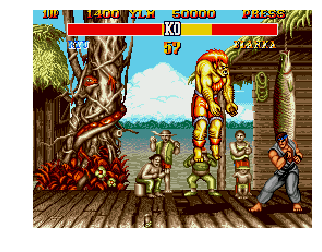

Episode: 0 Total reward: -53.0 Explore P: 0.9858 Training Loss 12.9979
Model Saved


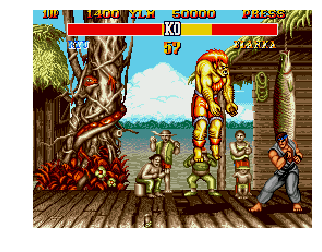

In [13]:
# Saver will help us to save our model
saver = tf.train.Saver()
training = True
total_episodes = 1
episode_render = True
if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            state = state.flatten()
            
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                #print(action)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(action)
                
                if episode_render and step % 100 == 0 :
                    plt.imshow(env.render(mode='rgb_array'))
                    plt.axis('off')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros(188*71+2, dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    next_staet = next_state.flatten()

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    #rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    next_state = next_state.flatten()
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                #print(np.array(batch).shape)
                states_mb = np.array([each[0] for each in batch], ndmin=1)
                #print(states_mb.shape)
                
                #actions_mb = np.array([each[1] for each in batch])
                list_agg = []
                for each in batch:
                    a_list = [0]*63
                    a_list[each[1]-1] = 1
                    list_agg.append(a_list)
                actions_mb = np.array(list_agg, ndmin=2)
                
                
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=1)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                for i, v in enumerate(next_states_mb):
                    if len(v) == 13350:
                        print(i)
                
                
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")

## Step 9: Test and Watch our Agent play 👀
Now that we trained our agent, we can test it

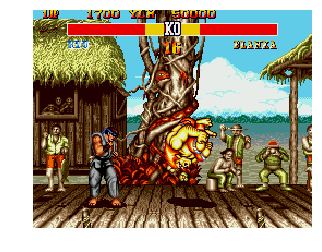

Score -1.0


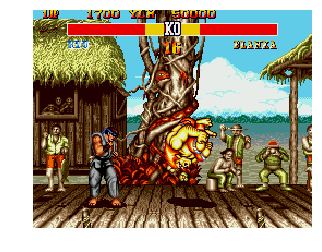

In [14]:
plt.figure(3)
plt.clf()

env.close()
saver = tf.train.Saver()
env = env = SF2Env(rom_path, 
                   'rvsb.state', 
                   scenario='scenario',
                   players=1,
                   use_restricted_actions=retro.Actions.DISCRETE)

with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    
    for episode in range(2):
        total_rewards = 0
        
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        t = 0
        while True:
            t += 1
            # Reshape the state
            state = state.reshape((1, state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            a_list = [0]*63
            a_list[choice] = 1
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
            
            if t % 20 == 0:
                plt.imshow(env.render(mode='rgb_array'))
                plt.axis('off')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            next_state = next_state.flatten()
            state = next_state
            
    env.close()

In [ ]:
env.close()